# MoleculeLineList Examples

This notebook demonstrates the features of the `MoleculeLineList` class, which provides efficient access to molecular line data from HITRAN format files.

## Key Features

- **Lazy loading** — Data is only loaded when first accessed
- **Binary caching** — Parsed data is cached for fast subsequent loads
- **Pandas integration** — Easy conversion to DataFrames for analysis
- **Efficient array access** — Direct numpy array access to all line properties
- **Wavelength filtering** — Get lines within specific wavelength ranges
- **Partition function access** — Access temperature-dependent partition functions

## Line Properties Available

| Property | Description | Units |
|----------|-------------|-------|
| `lam` | Wavelength | $\mu m$ |
| `freq` | Frequency | Hz |
| `a_stein` | Einstein A coefficient | $s^{-1}$ |
| `e_up` | Upper state energy | K |
| `e_low` | Lower state energy | K |
| `g_up` | Upper state degeneracy | - |
| `g_low` | Lower state degeneracy | - |
| `lev_up` | Upper quantum state label | - |
| `lev_low` | Lower quantum state label | - |

In [88]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

# Navigate from notebook location to the iSLATTests directory
notebook_dir = Path.cwd()
islat_root = notebook_dir.parent.parent.parent  # DataTypes -> Notebooks -> Examples -> iSLATTests
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import MoleculeLineList
from iSLAT.Modules.DataTypes.MoleculeLineList import MoleculeLineList

print("Imports successful!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Imports successful!
Pandas version: 2.3.3
NumPy version: 2.3.5


## 1. Loading Molecular Data

The `MoleculeLineList` class loads HITRAN format `.par` files. The first load parses the file and creates a binary cache for fast subsequent loads.

In [89]:
# Define path to HITRAN data files
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"

# Load H2O line list
h2o_lines = MoleculeLineList(
    molecule_id="H2O",
    filename=str(data_dir / "data_Hitran_H2O.par")
)

# Basic properties
print(f"Molecule: {h2o_lines.name}")
print(f"Number of lines: {h2o_lines.num_lines:,}")
print(f"Molar mass: {h2o_lines.molar_mass} g/mol")

Molecule: H2O
Number of lines: 305,561
Molar mass: 18.010565 g/mol


In [ ]:
# Load additional molecules for comparison
molecules = {}

molecule_files = {
    "H2O": "data_Hitran_H2O.par",
    "CO": "data_Hitran_CO.par",
    "CO2": "data_Hitran_CO2.par",
    "HCN": "data_Hitran_HCN.par",
    "C2H2": "data_Hitran_C2H2.par",
}

for mol_name, filename in molecule_files.items():
    filepath = data_dir / filename
    if filepath.exists():
        molecules[mol_name] = MoleculeLineList(
            molecule_id=mol_name,
            filename=str(filepath)
        )
        print(f"{mol_name}: {molecules[mol_name].num_lines:,} lines")

H2O: 305,561 lines
CO: 1,334 lines
CO2: 173,129 lines
HCN: 127,972 lines
C2H2: 81,454 lines


## 2. Accessing Line Properties as NumPy Arrays

The class provides fast array access methods for efficient numerical analysis.

In [91]:
# Get all line properties as numpy arrays
wavelengths = h2o_lines.get_wavelengths()       # μm
frequencies = h2o_lines.get_frequencies()        # Hz
einstein_A = h2o_lines.get_einstein_coefficients()  # s^-1
e_upper = h2o_lines.get_upper_energies()        # K
e_lower = h2o_lines.get_lower_energies()        # K
g_upper = h2o_lines.get_upper_weights()         # degeneracy
g_lower = h2o_lines.get_lower_weights()         # degeneracy

print("Array shapes and types:")
print(f"  wavelengths: {wavelengths.shape}, dtype={wavelengths.dtype}")
print(f"  frequencies: {frequencies.shape}, dtype={frequencies.dtype}")
print(f"  einstein_A:  {einstein_A.shape}, dtype={einstein_A.dtype}")
print(f"  e_upper:     {e_upper.shape}, dtype={e_upper.dtype}")
print(f"  e_lower:     {e_lower.shape}, dtype={e_lower.dtype}")

print("\nWavelength statistics:")
print(f"  Range: {wavelengths.min():.2f} - {wavelengths.max():.2f} μm")
print(f"  Median: {np.median(wavelengths):.2f} μm")

print("\nEnergy level statistics:")
print(f"  Upper E range: {e_upper.min():.0f} - {e_upper.max():.0f} K")
print(f"  Lower E range: {e_lower.min():.0f} - {e_lower.max():.0f} K")

Array shapes and types:
  wavelengths: (305561,), dtype=float64
  frequencies: (305561,), dtype=float64
  einstein_A:  (305561,), dtype=float64
  e_upper:     (305561,), dtype=float64
  e_lower:     (305561,), dtype=float64

Wavelength statistics:
  Range: 0.30 - 933.28 μm
  Median: 0.77 μm

Energy level statistics:
  Upper E range: 53 - 50404 K
  Lower E range: 0 - 9708 K


In [92]:
# Quick numpy-based analysis example
# Calculate transition energy (delta E = E_upper - E_lower)
delta_E = e_upper - e_lower

# Find the strongest lines (highest Einstein A)
strongest_idx = np.argsort(einstein_A)[-10:][::-1]  # Top 10

print("Top 10 strongest H2O lines (by Einstein A coefficient):")
print(f"{'Wavelength (μm)':>15} {'Einstein A (s^-1)':>18} {'ΔE (K)':>12}")
print("-" * 48)
for idx in strongest_idx:
    print(f"{wavelengths[idx]:>15.4f} {einstein_A[idx]:>18.3e} {delta_E[idx]:>12.1f}")

Top 10 strongest H2O lines (by Einstein A coefficient):
Wavelength (μm)  Einstein A (s^-1)       ΔE (K)
------------------------------------------------
         1.4583          3.006e+06       9866.2
         1.4507          2.360e+05       9917.8
         1.4873          2.265e+05       9673.7
         1.4456          2.065e+04       9952.6
         1.4349          5.688e+03      10026.6
         1.3941          4.314e+03      10320.8
         1.4824          2.488e+03       9705.8
         1.4349          2.071e+03      10027.0
         1.4880          2.065e+03       9669.3
         1.4721          1.145e+03       9773.4


## 3. Pandas Integration

The `MoleculeLineList` class integrates seamlessly with pandas for powerful data analysis.

In [93]:
# Get all line data as a pandas DataFrame
df = h2o_lines.get_pandas_table()

print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
df.head(10)

DataFrame shape: (305561, 10)

Columns: ['nr', 'lev_up', 'lev_low', 'lam', 'freq', 'a_stein', 'e_up', 'e_low', 'g_up', 'g_low']

Memory usage: 50.50 MB


,nr,lev_up,lev_low,lam,freq,a_stein,e_up,e_low,g_up,g_low
0,0,0_0_0|10_2_9,0_0_0|9_3_6,933.27661,3.212257e+11,0.000006,1861.25073,1845.83411,63,57
1,1,0_0_1|5_1_5,0_0_1|4_2_2,928.22180,3.229750e+11,0.000009,5865.74316,5850.24268,33,27
2,2,0_2_0|6_5_1,0_2_0|7_4_4,926.64453,3.235247e+11,0.000026,6039.06494,6023.53857,13,15
3,3,0_1_0|14_3_12,0_1_0|13_4_9,926.56085,3.235540e+11,0.000009,6021.03809,6005.50977,87,81
4,4,0_0_0|5_1_5,0_0_0|4_2_2,922.00464,3.251529e+11,0.000012,469.94110,454.33624,11,9
5,5,1_0_0|5_1_5,1_0_0|4_2_2,917.67560,3.266867e+11,0.000010,5722.67236,5706.99365,11,9
6,6,0_2_0|3_2_1,0_2_0|4_1_4,905.37897,3.311237e+11,0.000033,4881.40918,4865.51709,21,27
7,7,0_1_0|5_2_3,0_1_0|6_1_6,891.63464,3.362279e+11,0.000011,2955.20264,2939.06616,33,39
8,8,0_0_0|16_6_11,0_0_0|17_3_14,884.22882,3.390440e+11,0.000008,5499.35889,5483.08691,99,105
9,9,0_0_0|17_4_13,0_0_0|16_7_10,844.94141,3.548086e+11,0.000009,5780.87305,5763.84570,105,99


In [94]:
# Statistical summary of numeric columns
df[['lam', 'freq', 'a_stein', 'e_up', 'e_low', 'g_up', 'g_low']].describe()

,lam,freq,a_stein,e_up,e_low,g_up,g_low
count,305561.000000,3.055610e+05,3.055610e+05,305561.000000,305561.000000,305561.000000,305561.000000
mean,2.390712,4.168140e+14,1.230499e+01,22502.379223,2498.463929,34.529423,34.130864
std,14.149397,2.482644e+14,5.470258e+03,10815.266303,1847.209737,23.610707,23.382645
min,0.300000,3.212257e+11,9.266000e-13,53.432040,0.000000,1.000000,1.000000
25%,0.505230,2.162986e+14,1.950000e-06,14011.840820,1013.206850,15.000000,15.000000
50%,0.768630,3.900351e+14,1.098000e-04,21038.271480,2122.168210,27.000000,27.000000
75%,1.386010,5.933733e+14,9.991000e-03,29958.613280,3614.747560,51.000000,51.000000
max,933.276610,9.993031e+14,3.006000e+06,50404.351560,9708.096680,159.000000,153.000000


In [95]:
# Example: Filter lines in a specific wavelength range
miri_range = df[(df['lam'] >= 5.0) & (df['lam'] <= 28.0)]
print(f"Lines in MIRI range (5-28 μm): {len(miri_range):,}")

# Example: Find lines with high optical depth potential (high A, low E_low)
strong_lines = df[
    (df['a_stein'] > df['a_stein'].quantile(0.99)) &  # Top 1% by Einstein A
    (df['e_low'] < 5000)  # Low-lying states
]
print(f"Strong low-energy lines: {len(strong_lines):,}")

# Show the filtered data
strong_lines.sort_values('a_stein', ascending=False).head(10)

Lines in MIRI range (5-28 μm): 13,089
Strong low-energy lines: 784


,nr,lev_up,lev_low,lam,freq,a_stein,e_up,e_low,g_up,g_low
33707,33707,0_2_1|0_0_0,0_2_0|1_0_1,2.70557,1.108057e+14,106.50,9886.58398,4568.75098,3,9
34028,34028,0_1_1|0_0_0,0_1_0|1_0_1,2.69345,1.113042e+14,98.58,7670.50391,2328.74243,3,9
34321,34321,0_0_1|0_0_0,0_0_0|1_0_1,2.67943,1.118866e+14,91.02,5403.94287,34.23483,3,9
5301,5301,0_0_0|12_12_1,0_0_0|11_11_0,18.17541,1.649440e+13,89.97,5418.99023,4627.38428,75,69
5302,5302,0_0_0|12_12_0,0_0_0|11_11_1,18.17541,1.649440e+13,89.96,5418.99023,4627.38428,25,23
5394,5394,0_0_0|13_11_3,0_0_0|12_10_2,17.71747,1.692073e+13,77.63,5512.21191,4700.14502,27,25
5395,5395,0_0_0|13_11_2,0_0_0|12_10_3,17.71747,1.692073e+13,77.62,5512.21191,4700.14502,81,75
5242,5242,0_0_0|12_11_1,0_0_0|11_10_2,18.53302,1.617613e+13,74.69,5053.56641,4277.23535,25,23
5241,5241,0_0_0|12_11_2,0_0_0|11_10_1,18.53302,1.617613e+13,74.69,5053.56641,4277.23535,75,69
5055,5055,0_0_0|11_11_1,0_0_0|10_10_0,19.44373,1.541847e+13,71.96,4627.38428,3887.41455,23,21


In [96]:
# Example: Group lines by wavelength bins and analyze
df['wavelength_bin'] = pd.cut(df['lam'], bins=np.arange(0, 30, 2))

# Count lines per wavelength bin
bin_stats = df.groupby('wavelength_bin', observed=True).agg({
    'lam': 'count',
    'a_stein': ['mean', 'max'],
    'e_low': 'mean'
}).round(3)

bin_stats.columns = ['n_lines', 'mean_A', 'max_A', 'mean_E_low']
print("Line statistics by wavelength bin:")
bin_stats

Line statistics by wavelength bin:


,n_lines,mean_A,max_A,mean_E_low
wavelength_bin,,,,
"(0, 2]",259102,13.773,3006000.00,2154.156
"(2, 4]",25950,3.930,148.40,3986.208
"(4, 6]",7462,1.782,52.03,4566.859
"(6, 8]",4168,6.089,93.26,4866.438
"(8, 10]",1288,4.056,57.61,5215.314
"(10, 12]",655,1.224,25.78,4608.329
"(12, 14]",560,8.206,190.20,5013.569
"(14, 16]",589,18.478,205.70,5501.574
"(16, 18]",448,14.816,131.50,5313.103


In [97]:
# Example: Analyze energy level distribution
# Create energy bins for lower state
df['e_low_bin'] = pd.cut(df['e_low'], bins=[0, 1000, 2000, 5000, 10000, 20000, 50000])

energy_distribution = df.groupby('e_low_bin', observed=True).agg({
    'lam': 'count',
    'a_stein': 'mean',
    'lam': lambda x: f"{x.min():.2f}-{x.max():.2f}"
}).rename(columns={'lam': 'wavelength_range'})

# Get counts separately
counts = df.groupby('e_low_bin', observed=True).size()
energy_distribution['n_lines'] = counts

print("Lines grouped by lower state energy:")
energy_distribution

Lines grouped by lower state energy:


,wavelength_range,a_stein,n_lines
e_low_bin,,,
"(0, 1000]",0.30-922.00,0.093387,75524
"(1000, 2000]",0.30-933.28,0.108435,70572
"(2000, 5000]",0.30-905.38,0.461838,121983
"(5000, 10000]",0.61-928.22,99.375758,37120


## 4. Wavelength Range Filtering

The class provides efficient methods for extracting lines within specific wavelength ranges.

In [98]:
# Get lines in a specific wavelength range (returns MoleculeLine objects)
lines_14_16 = h2o_lines.get_lines_in_range(14.0, 16.0)

print(f"Lines between 14-16 μm: {len(lines_14_16):,}")

# Access individual line properties
if lines_14_16:
    line = lines_14_16[0]
    print(f"\nFirst line properties:")
    print(f"  Wavelength: {line.lam:.4f} μm")
    print(f"  Frequency: {line.freq:.3e} Hz")
    print(f"  Einstein A: {line.a_stein:.3e} s^-1")
    print(f"  Upper level: {line.lev_up}")
    print(f"  Lower level: {line.lev_low}")
    print(f"  E_upper: {line.e_up:.1f} K")
    print(f"  E_lower: {line.e_low:.1f} K")

Lines between 14-16 μm: 589

First line properties:
  Wavelength: 15.9957 μm
  Frequency: 1.874e+13 Hz
  Einstein A: 7.838e+01 s^-1
  Upper level: 0_1_0|15_10_6
  Lower level: 0_1_0|14_9_5
  E_upper: 8751.2 K
  E_lower: 7851.8 K


In [99]:
# Alternative: Use pandas for more flexible filtering
def get_lines_dataframe(line_list, lam_min, lam_max):
    """Get lines in a wavelength range as a DataFrame."""
    df = line_list.get_pandas_table()
    return df[(df['lam'] >= lam_min) & (df['lam'] <= lam_max)].copy()

# Get JWST MIRI-relevant lines
df_miri = get_lines_dataframe(h2o_lines, 4.9, 28.8)

# Add calculated columns
df_miri['delta_E'] = df_miri['e_up'] - df_miri['e_low']
df_miri['log_A'] = np.log10(df_miri['a_stein'])

print(f"H2O lines in MIRI range: {len(df_miri):,}")
print(f"\nTransition energy (ΔE) statistics:")
print(df_miri['delta_E'].describe())

H2O lines in MIRI range: 13,523

Transition energy (ΔE) statistics:
count    13523.000000
mean      1879.839404
std        723.778321
min        499.927740
25%       1238.478510
50%       2049.099120
75%       2488.569580
max       2935.690430
Name: delta_E, dtype: float64


## 5. Partition Function Access

The partition function Q(T) is essential for calculating level populations and is stored alongside the line data.

In [100]:
# Get partition function as a DataFrame
partition_df = h2o_lines.get_partition_table()

print(f"Partition function table shape: {partition_df.shape}")
print(f"Temperature range: {partition_df['Temperature'].min():.0f} - {partition_df['Temperature'].max():.0f} K")

# Display sample values
partition_df.head(10)

Partition function table shape: (5000, 2)
Temperature range: 1 - 5000 K


,Temperature,Partition_Function
0,1.0,1.00000
1,2.0,1.00000
2,3.0,1.00010
3,4.0,1.00173
4,5.0,1.00968
5,6.0,1.03069
6,7.0,1.07059
7,8.0,1.13288
8,9.0,1.21889
9,10.0,1.32837


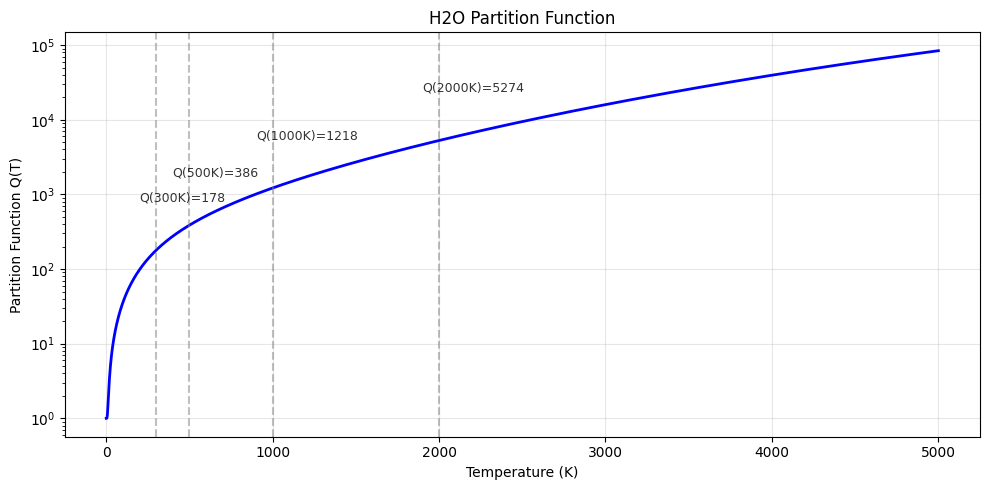

In [101]:
# Plot partition function
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(partition_df['Temperature'], partition_df['Partition_Function'], 'b-', linewidth=2)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Partition Function Q(T)')
ax.set_title(f'{h2o_lines.name} Partition Function')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Mark some common temperatures
for T in [300, 500, 1000, 2000]:
    idx = (partition_df['Temperature'] - T).abs().idxmin()
    Q = partition_df.loc[idx, 'Partition_Function']
    ax.axvline(T, color='gray', linestyle='--', alpha=0.5)
    ax.annotate(f'Q({T}K)={Q:.0f}', xy=(T, Q), xytext=(T-100, Q*4.5),
                fontsize=9, alpha=0.8)

plt.tight_layout()
plt.show()

In [102]:
# Example: Interpolate partition function for arbitrary temperatures
from scipy import interpolate

# Create interpolation function
Q_interp = interpolate.interp1d(
    partition_df['Temperature'],
    partition_df['Partition_Function'],
    kind='cubic',
    fill_value='extrapolate'
)

# Get Q for specific temperatures
temps = np.array([300, 500, 850, 1000, 1500, 2000])
Q_values = Q_interp(temps)

print("Interpolated partition function values:")
for T, Q in zip(temps, Q_values):
    print(f"  Q({T:4d} K) = {Q:.2f}")

Interpolated partition function values:
  Q( 300 K) = 178.12
  Q( 500 K) = 386.33
  Q( 850 K) = 913.67
  Q(1000 K) = 1218.07
  Q(1500 K) = 2712.10
  Q(2000 K) = 5274.25


## 6. Visualization Examples with Pandas

Using pandas and matplotlib together for line list visualization.

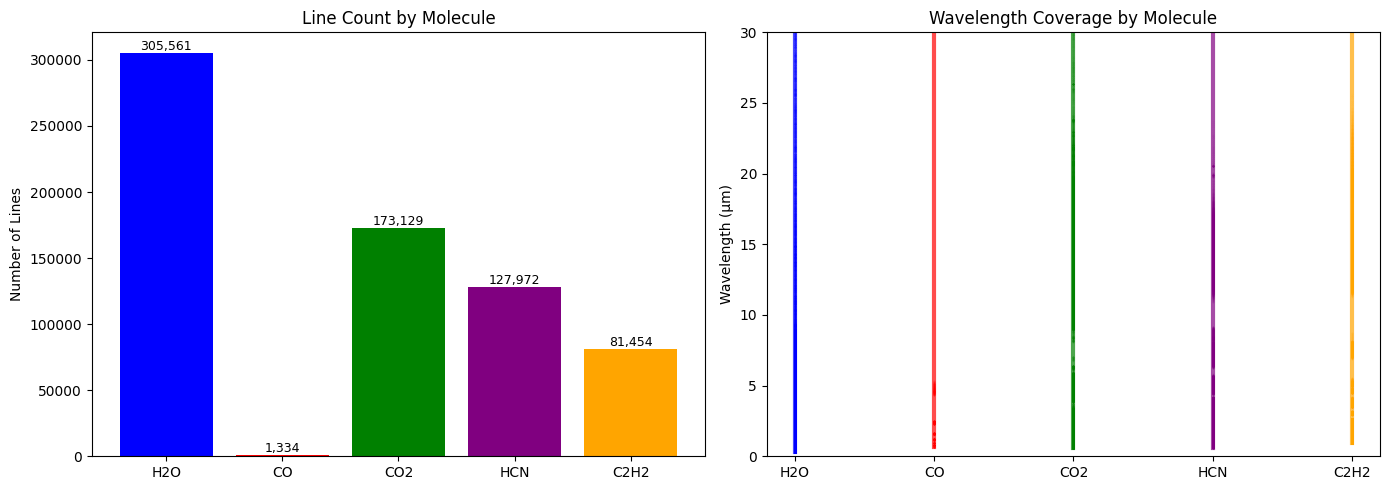

In [103]:
# Compare line distributions across molecules
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Colors for each molecule
colors = {'H2O': 'blue', 'CO': 'red', 'CO2': 'green', 'HCN': 'purple', 'C2H2': 'orange'}

# Panel 1: Line count comparison
ax1 = axes[0]
mol_names = list(molecules.keys())
line_counts = [molecules[m].num_lines for m in mol_names]
bars = ax1.bar(mol_names, line_counts, color=[colors.get(m, 'gray') for m in mol_names])
ax1.set_ylabel('Number of Lines')
ax1.set_title('Line Count by Molecule')
ax1.bar_label(bars, fmt='{:,.0f}', fontsize=9)

# Panel 2: Wavelength coverage
ax2 = axes[1]
for i, (mol_name, mol) in enumerate(molecules.items()):
    wavelengths = mol.get_wavelengths()
    ax2.scatter([mol_name]*len(wavelengths), wavelengths, s=0.1, alpha=0.1, 
                c=colors.get(mol_name, 'gray'))
    # Add range bars
    ax2.plot([mol_name, mol_name], [wavelengths.min(), wavelengths.max()], 
             c=colors.get(mol_name, 'gray'), linewidth=3, alpha=0.7)

ax2.set_ylabel('Wavelength (μm)')
ax2.set_title('Wavelength Coverage by Molecule')
ax2.set_ylim(0, 30)

plt.tight_layout()
plt.show()

## 7. Pandas Exporting Example

In [104]:
# Example: Export filtered lines to CSV
# Select strong lines in MIRI range suitable for detection

detectable_lines = df[
    (df['lam'] >= 4.9) & (df['lam'] <= 28.8) &  # MIRI range
    (df['a_stein'] > 1e-2) &  # Select transition
    (df['e_low'] < 10000)  # Set temperature
].copy()

# Sort by strength
detectable_lines = detectable_lines.sort_values('a_stein', ascending=False)

print(f"Potentially detectable H2O lines: {len(detectable_lines):,}")
print(f"\nTop 20 strongest detectable lines:")
detectable_lines[['lam', 'a_stein', 'e_low', 'e_up', 'g_up', 'g_low']].head(20)

Potentially detectable H2O lines: 9,980

Top 20 strongest detectable lines:


,lam,a_stein,e_low,e_up,g_up,g_low
6306,14.21061,205.7,9050.16992,10062.63574,35,33
6305,14.21061,205.6,9050.16992,10062.63574,105,99
6443,13.76219,190.2,9252.37305,10297.83105,37,35
6444,13.76219,190.2,9252.37305,10297.83105,111,105
6291,14.24957,184.8,8650.42188,9660.12109,105,99
6290,14.24957,184.7,8650.42188,9660.12109,35,33
6137,14.79079,179.5,8077.41846,9050.16992,99,93
6136,14.79079,179.5,8077.41846,9050.16992,33,31
6552,13.41866,174.6,9468.67188,10540.89258,117,111
6551,13.41866,174.6,9468.67188,10540.89258,39,37


In [105]:
# Save to CSV (commented out to avoid creating files)
# detectable_lines.to_csv('h2o_detectable_lines.csv', index=False)

# Or save to Excel with multiple sheets
# with pd.ExcelWriter('h2o_analysis.xlsx') as writer:
#     df.to_excel(writer, sheet_name='All Lines', index=False)
#     detectable_lines.to_excel(writer, sheet_name='Detectable', index=False)
#     partition_df.to_excel(writer, sheet_name='Partition Function', index=False)

print("Data export examples (code commented out)")
print("Uncomment the code above to save data to files.")

Data export examples (code commented out)
Uncomment the code above to save data to files.


## Summary

The `MoleculeLineList` class provides:

| Feature | Method/Property | Description |
|---------|-----------------|-------------|
| **Loading** | `MoleculeLineList(molecule_id, filename)` | Load from HITRAN .par file |
| **Basic info** | `.name`, `.num_lines`, `.molar_mass` | Molecule properties |
| **Array access** | `.get_wavelengths()`, `.get_frequencies()`, etc. | Fast numpy array access |
| **Pandas** | `.get_pandas_table()` | Full DataFrame conversion |
| **Partition** | `.get_partition_table()` | Temperature-dependent Q(T) |
| **Filtering** | `.get_lines_in_range(lam_min, lam_max)` | Get lines in wavelength range |
| **Generic** | `.get_ndarray_of_attribute(name)` | Get any attribute as array |

The pandas integration makes it easy to:
- Filter and query line data
- Calculate statistics and aggregations
- Create pivot tables for multi-dimensional analysis
- Export data to various formats (CSV, Excel, etc.)
- Integrate with visualization libraries